In [1]:

!git clone https://github.com/CheyneyComputerScience/CREMA-D

Cloning into 'CREMA-D'...
remote: Enumerating objects: 22501, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (60/60), done.:  96% (58/60)
remote: Total 22501 (delta 22), reused 57 (delta 13), pack-reused 22428 (from 1)
Receiving objects: 100% (22501/22501), 14.82 MiB | 19.28 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Updating files: 100% (22342/22342), done.
Filtering content: 100% (22326/22326), 3.42 GiB | 8.76 MiB/s, done.


In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")


data_dir = 'CREMA-D/AudioWAV'

paths = []
labels = []


for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[2].lower()  # Extract emotion from filename
            labels.append(label)


df = pd.DataFrame()
df['Speech'] = paths
df['Label'] = labels


df.sample(5)


,Speech,Label
252,CREMA-D/AudioWAV/1014_TAI_ANG_XX.wav,ang
6590,CREMA-D/AudioWAV/1041_WSI_NEU_XX.wav,neu
3193,CREMA-D/AudioWAV/1066_TSI_FEA_XX.wav,fea
6192,CREMA-D/AudioWAV/1026_ITH_SAD_XX.wav,sad
4950,CREMA-D/AudioWAV/1039_IWW_NEU_XX.wav,neu


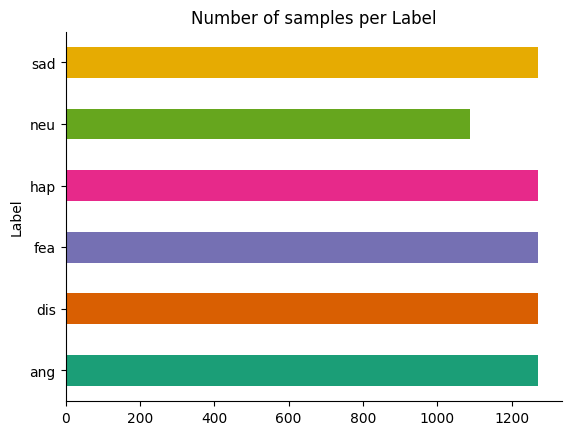

In [3]:

df.groupby('Label').size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.title('Number of samples per Label')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [4]:

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc


X_mfcc = df['Speech'].apply(lambda x: extract_mfcc(x))


X = np.array([x for x in X_mfcc])


X = np.expand_dims(X, -1)


y = OneHotEncoder().fit_transform(df[['Label']]).toarray()

In [5]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(40, 1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')  # CREMA-D has 6 emotion classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,094 (301.15 KB)

 Trainable params: 77,094 (301.15 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1671 - loss: 1.7921 - val_accuracy: 0.2469 - val_loss: 1.7375
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2448 - loss: 1.7264 - val_accuracy: 0.3090 - val_loss: 1.6196
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2813 - loss: 1.6478 - val_accuracy: 0.3174 - val_loss: 1.5767
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3002 - loss: 1.6149 - val_accuracy: 0.3434 - val_loss: 1.5589
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3248 - loss: 1.5829 - val_accuracy: 0.3484 - val_loss: 1.5336
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3468 - loss: 1.5406 - val_accuracy: 0.3568 - val_loss: 1.5230
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3411 - loss: 1.5319 - val_accuracy: 0.3610 - val_loss: 1.4891
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3762 - loss: 1.5049 - val_accuracy: 0.3661 - val_loss

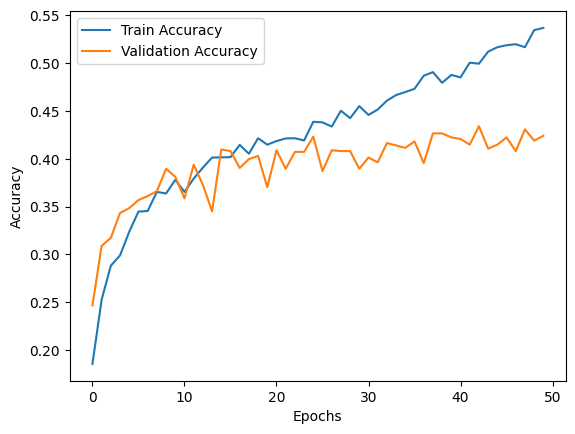

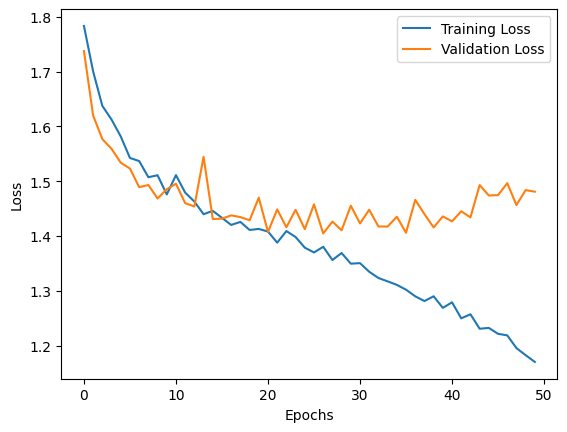

In [8]:

epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[181  29  12  37   8   0]
 [ 38  87  11  33  54  40]
 [ 20  24  75  55  28  56]
 [ 52  45  35  86  24  13]
 [  5  45  14  29  84  23]
 [  4  29  23   9  46 135]]
              precision    recall  f1-score   support

       angry       0.60      0.68      0.64       267
     disgust       0.34      0.33      0.33       263
        fear       0.44      0.29      0.35       258
       happy       0.35      0.34      0.34       255
     neutral       0.34      0.42      0.38       200
         sad       0.51      0.55      0.53       246

    accuracy                           0.44      1489
   macro avg       0.43      0.43      0.43      1489
weighted avg       0.43      0.44      0.43      1489



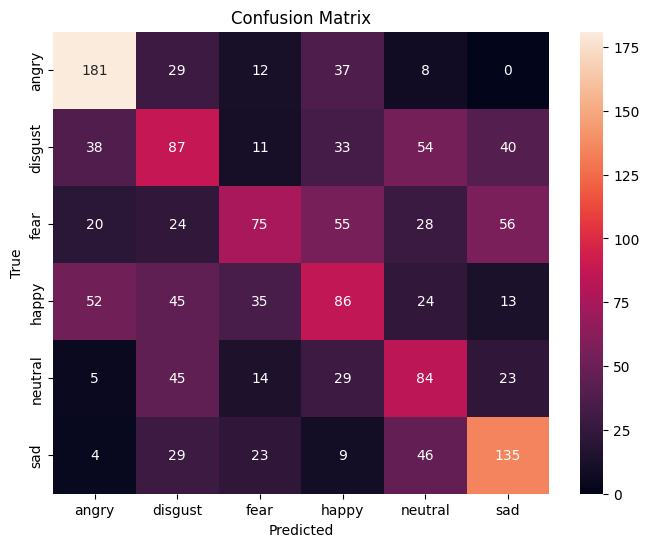

In [9]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

conf_mat = confusion_matrix(y_val_classes, y_pred_classes)
print(conf_mat)

target_names = ["angry", "disgust", "fear", "happy", "neutral", "sad"]
print(classification_report(y_val_classes, y_pred_classes, target_names=target_names))

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()